# pre trained model wigths

In [8]:
# Commented out IPython magic to ensure Python compatibility.
import os
!pip install Keras-Preprocessing
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# %matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

# Fixed imports for TensorFlow 2.x
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, BatchNormalization, Activation, Dense, Dropout,
    Lambda, RepeatVector, Reshape,
    Conv2D, Conv2DTranspose,
    MaxPooling2D, GlobalMaxPool2D, AveragePooling2D,
    GlobalAveragePooling2D, GlobalMaxPooling2D, Permute, 
    Concatenate, Add, Multiply
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet121
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2B1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers, models

import cv2
import skimage.io as io
import skimage.transform as trans
import glob
from PIL import Image
import skimage
from skimage.morphology import disk
from sklearn.metrics import confusion_matrix, roc_curve, auc, jaccard_score, precision_recall_curve
from skimage.measure import label, regionprops

import zipfile
import random
import sys
import warnings
warnings.filterwarnings("ignore")
random.seed(42)

# Custom loss and metric functions
def dice_coef(y_true, y_pred, smooth=10):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def Jaccard_coef_loss(y_true, y_pred):
    return 1 - Jaccard_coef(y_true, y_pred)

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def sensitivity(y_train, results):
    true_positives = K.sum(K.round(K.clip(y_train * results, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    sensitivity = true_positives / (actual_positives + K.epsilon())
    return sensitivity

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    result = 1 - tf.divide(nominator, denominator)
    return result

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return DiceLoss(y_true, y_pred, smooth=1e-6) + (1 - iou(y_true, y_pred, threshold=0.5))

# CBAM attention module
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# TransFuse Network
def create_transfuse_net(input_shape):
    # Define the input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    # Encoder - Transformer Block
    transformer_block = layers.Reshape((-1, conv_block3.shape[3]))(conv_block3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=32)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1, 1, transformer_block.shape[1]))(transformer_block)

    # Tile the transformer block output to match the spatial dimensions of the convolutional block
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv_block3.shape[1], conv_block3.shape[2], 1]))(transformer_block)

    # Concatenate the Encoder Convolutional and Transformer blocks
    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv_block3, att1])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2 = cbam_block(decoder_block1)
    decoder_block1 = layers.Concatenate()([att2, conv_block2])
    decoder_block1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)
    att3 = cbam_block(decoder_block2)
    decoder_block2 = layers.Concatenate()([att3, conv_block1])
    decoder_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)

    decoder_block3 = layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    
    # Decoder - Output Block
    output_BV = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output1')(decoder_block3)
    output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output2')(decoder_block3)

    # Create the model
    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])

    return model

# Define your input shape (e.g., 256x256x3 for RGB images)
input_shape = (256, 256, 3)

# Create the TransFuse Encoder-Decoder model
model = create_transfuse_net(input_shape)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │        224 │ input_layer_6[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1024, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1024, 32)  │     16,800 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ lambda[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ lambda[0][0]      │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 66,194 (258.57 KB)

 Trainable params: 66,082 (258.13 KB)

 Non-trainable params: 112 (448.00 B)

Creating model...

Loading weights from: /kaggle/input/pretrained/keras/default/1/MTLTransfuseep300bs16head4.h5
Weights loaded successfully!

Loading test data from: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test
Loading 20 images from /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test...
Done!

Running inference...


I0000 00:00:1763311868.560233     113 service.cc:148] XLA service 0x781bb4412320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763311868.560937     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763311868.560955     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763311868.785507     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763311880.447552     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Total Inference Time: 13.52 seconds
Inference Time per image: 0.6759 seconds

=== Blood Vessel Segmentation Metrics ===

F1_score: 0.9890, Dice: 0.9890, Jaccard: 0.9783, Sensitivity: 0.9949, Specificity: 0.9627

Predictions saved as 'predictions.png'


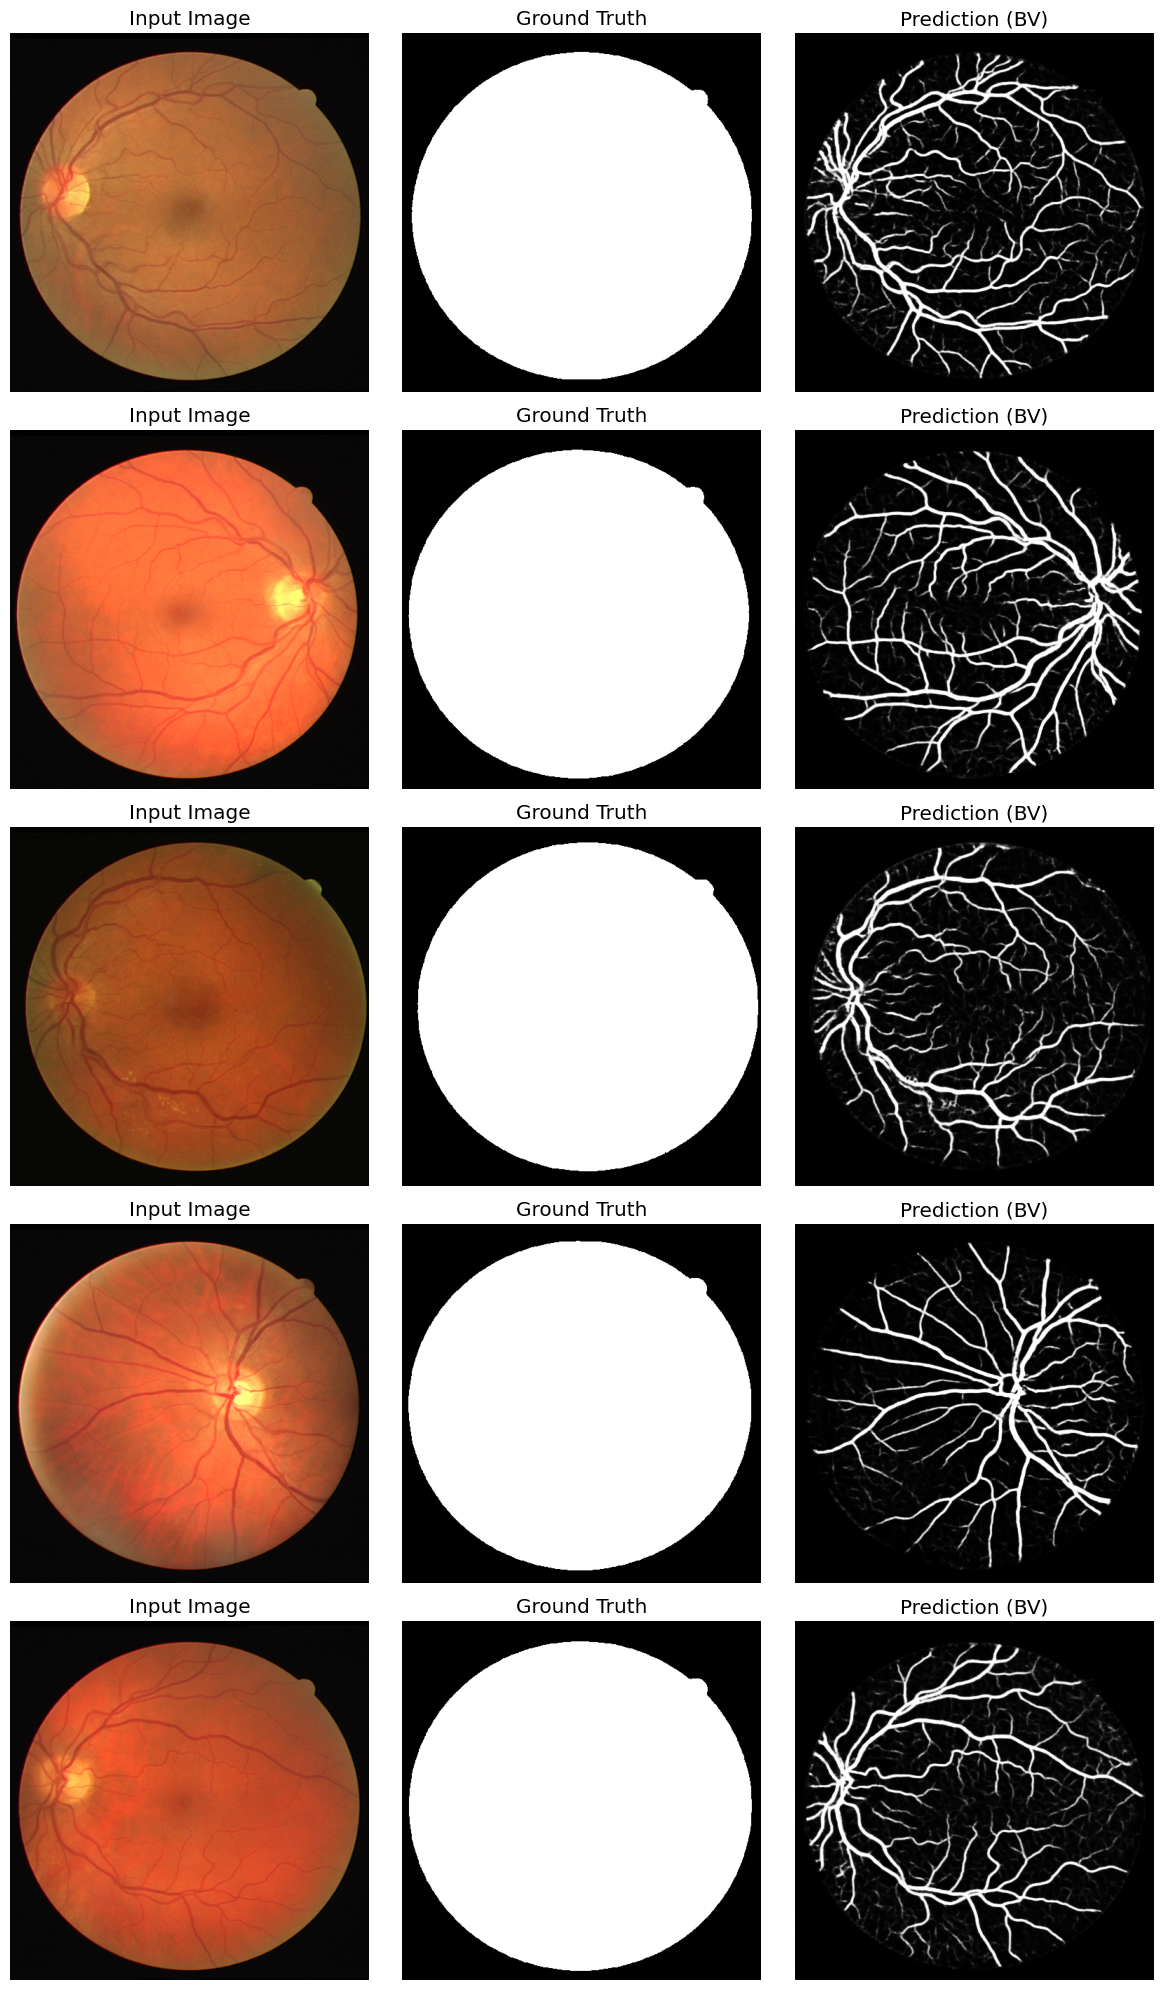


=== Evaluation Complete ===


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense,
    Activation, Add, Multiply, Permute, Concatenate, Conv2D, Lambda
)
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, precision_recall_curve
import warnings
import time
warnings.filterwarnings("ignore")

# ==================== CUSTOM METRICS & LOSS FUNCTIONS ====================
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def sensitivity(y_train, results):
    true_positives = K.sum(K.round(K.clip(y_train * results, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    result = 1 - tf.divide(nominator, denominator)
    return result

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return DiceLoss(y_true, y_pred, smooth=1e-6) + (1 - iou(y_true, y_pred, threshold=0.5))

# ==================== CBAM ATTENTION MODULE ====================
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio, activation='relu', 
                             kernel_initializer='he_normal', use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1,
                         padding='same', activation='sigmoid',
                         kernel_initializer='he_normal', use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# ==================== MODEL ARCHITECTURE ====================
def create_transfuse_net(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    # Encoder - Transformer Block
    transformer_block = layers.Reshape((-1, conv_block3.shape[3]))(conv_block3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=16)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1, 1, transformer_block.shape[1]))(transformer_block)
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv_block3.shape[1], conv_block3.shape[2], 1]))(transformer_block)

    # Fusion with CBAM
    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv_block3, att1])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2 = cbam_block(decoder_block1)
    decoder_block1 = layers.Concatenate()([att2, conv_block2])
    decoder_block1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)
    att3 = cbam_block(decoder_block2)
    decoder_block2 = layers.Concatenate()([att3, conv_block1])
    decoder_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)

    decoder_block3 = layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    
    # Decoder - Output Block
    output_BV = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output1')(decoder_block3)
    output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output2')(decoder_block3)

    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])
    return model

# ==================== DATA LOADING FUNCTION ====================
def get_data(path, im_height=512, im_width=512):
    images_path = os.path.join(path, 'images')
    masks_path_BV = os.path.join(path, 'mask')  # DRIVE test uses 'mask' folder
    
    # Get sorted image files
    images_ids = sorted([f for f in os.listdir(images_path) if f.endswith(('.tif', '.png', '.jpg'))])
    
    n_images = len(images_ids)
    X = np.zeros((n_images, im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((n_images, im_height, im_width, 1), dtype=np.float32)
    
    print(f'Loading {n_images} images from {path}...')
    for n in range(n_images):
        img_name = images_ids[n]
        
        # Load images
        img = img_to_array(load_img(os.path.join(images_path, img_name), color_mode='rgb'))
        x_img = resize(img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
        # Load corresponding mask (e.g., 01_test.tif -> 01_test_mask.gif)
        mask_name = img_name.replace('.tif', '_mask.gif').replace('.png', '_mask.gif').replace('.jpg', '_mask.gif')
        mask_path = os.path.join(masks_path_BV, mask_name)
        
        if os.path.exists(mask_path):
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        else:
            print(f"Warning: Mask not found for {img_name}, using zeros")
            mask = np.zeros((im_height, im_width, 1), dtype=np.float32)
        
        # Normalize
        X[n] = x_img / 255.0
        y[n] = mask / 255.0
    
    print('Done!')
    return X, y

# ==================== EVALUATION METRICS ====================
def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_F1_score = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)
        
        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        max_value = np.argmax(f1)
        thres = thresholds[max_value] if max_value < len(thresholds) else 0.5
        pred_label = (pred_flt >= thres).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()
        
        all_F1_score[i] = tp / (tp + 0.5 * (fp + fn) + 1e-10)
        all_jaccard[i] = tp / (tp + fp + fn + 1e-10)
        all_dice[i] = 2 * tp / (2 * tp + fp + fn + 1e-10)
        all_specificity[i] = tn / (tn + fp + 1e-10)
        all_sensitivity[i] = tp / (tp + fn + 1e-10)
    
    print(f'\nF1_score: {np.nanmean(all_F1_score):.4f}, Dice: {np.nanmean(all_dice):.4f}, '
          f'Jaccard: {np.nanmean(all_jaccard):.4f}, Sensitivity: {np.nanmean(all_sensitivity):.4f}, '
          f'Specificity: {np.nanmean(all_specificity):.4f}')
    
    return all_F1_score, all_dice, all_jaccard, all_sensitivity, all_specificity

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # Paths
    weights_path = '/kaggle/input/pretrained/keras/default/1/MTLTransfuseep300bs16head4.h5'
    test_data_path = '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test'
    
    # Create model
    input_shape = (512, 512, 3)
    print("Creating model...")
    model = create_transfuse_net(input_shape)
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
        metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                 'final_output2': [dice_coef, iou, sensitivity, specificity]}
    )
    
    # Load weights
    print(f"\nLoading weights from: {weights_path}")
    model.load_weights(weights_path)
    print("Weights loaded successfully!")
    
    # Load test data
    print(f"\nLoading test data from: {test_data_path}")
    X_test, y_test = get_data(test_data_path)
    
    # Convert ground truth to binary
    y_test_binary = (y_test > 0.5).astype(np.uint8)
    
    # Make predictions
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(X_test, verbose=1)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Inference Time per image: {inference_time/len(X_test):.4f} seconds")
    
    # Evaluate metrics for BV (Blood Vessel) task
    print("\n=== Blood Vessel Segmentation Metrics ===")
    eval_BV = evaluate_metrics(y_test_binary, predictions[0])
    
    # Visualize some predictions
    num_samples = min(5, len(X_test))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax[0].imshow(X_test[i])
        ax[0].set_title('Input Image')
        ax[0].axis('off')
        
        ax[1].imshow(np.squeeze(y_test_binary[i]), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        
        ax[2].imshow(np.squeeze(predictions[0][i]), cmap='gray')
        ax[2].set_title('Prediction (BV)')
        ax[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\nPredictions saved as 'predictions.png'")
    plt.show()
    
    print("\n=== Evaluation Complete ===")